In [386]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
import access_spectrum as acs
from empca_residuals import *
from scipy.interpolate import interp1d
import os, glob
from apogee.tools import toApStarGrid,pix2wv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [387]:
import matplotlib
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  20 # Tune this according to personal preference
}

matplotlib.rc('font',**font)

default_cmap = 'plasma'
datadir = '/geir_data/scr/price-jones/Data/apogee_dim_reduction/'
figdir = '/home/price-jones/Documents/rc_dim_paper'

In [280]:
def getarrays(model):
    """                                                                                            
    Read out arrays associated with a model holding EMPCA information.
    
    model:     EMPCA model object
    """
    if model.savename:
        savename = model.savename.split('/')
        parts = [i for i in savename if 'seed' not in i]
        savename = ('/').join(parts)
        arc = np.load('{0}_data.npz'.format(savename))

        model.eigval = arc['eigval']
        model.eigvec = np.ma.masked_array(arc['eigvec'],
                                         mask=arc['eigvecmask'])
        model.coeff = arc['coeff']
    return model

        
def reconstruct_EMPCA_data(direc,model,minStarNum=5):
    """
    Reconstruct the data used in the EMPCA analysis (with appropriate weights)
    
    direc:        Directory where model files are stored
    model:        Model object to which attributes will be assigned
    minstarNum:   Minimum number of stars required to perform EMPCA on a given pixel, default 5
    """
    model = getarrays(model)
    # Find parent directory where basic spectral information is housed
    skimbm = direc.split('/')
    parentdirec = '/'.join(skimbm[:-1])
    # Load in uncertainties
    spectra_errs = np.load('{0}/spectra_errs.npy'.format(parentdirec))
    spectra = np.load('{0}/spectra.npy'.format(parentdirec))
    # Load in mask
    mask = np.load('{0}/mask.npy'.format(direc))
    # Load in fit residuals
    residuals = np.load('{0}/residuals.npy'.format(direc))
    fitspec = np.load('{0}/fitspectra.npy'.format(direc))
    residuals = np.ma.masked_array(residuals,mask=mask)
    # Find pixels with enough stars to do EMPCA                                                                                
    goodPixels=([i for i in range(aspcappix) if np.sum(residuals[:,i].mask) < residuals.shape[0]-minStarNum],)
    empcaResiduals = residuals.T[goodPixels].T

    # Calculate weights that just mask missing elements                                                                        
    unmasked = (empcaResiduals.mask==False)
    errorWeights = unmasked.astype(float)
    errorWeights[unmasked] = 1./((spectra_errs.T[goodPixels].T[unmasked])**2)
    # Assign attributes to the model
    model.residuals = residuals
    model.data = empcaResiduals
    model.weights = errorWeights
    model.fitspec = fitspec
    model.spectra = spectra
    model.spectra_errs=spectra_errs
    model.mask = mask
    return model
    

def consth(n,model,N,D):
    """
    Assume that all chemical space cells have the same size and calculate that size.
    n:          Number of eigenvectors for which to calculate cell size
    model:      EMPCA model object that contains eigenvalues
    N:          Number of measurements in the data set (i.e. number of stars)
    D:          Number of dimensions in each measurement (i.e. pixels)
    """
    hs = np.ones(n)
    hs = np.sqrt((1./len(model.weights[model.weights!=0]))*np.sum(1./model.weights[model.weights!=0]))*hs
    return hs  

def pessimh(n,model,N,D):
    """
    Assume that all chemical space cells have the same size and calculate that size.
    n:          Number of eigenvectors for which to calculate cell size
    model:      EMPCA model object that contains eigenvalues
    N:          Number of measurements in the data set (i.e. number of stars)
    D:          Number of dimensions in each measurement (i.e. pixels)
    """
    crossvec = np.where(model.R2Array > model.R2noise)
    if crossvec[0] != []:
        crossvec = crossvec[0][0] - 1
        print crossvec
        if crossvec < 0:
            crossvec = 0
        if D < N:
            hs = D*np.ones(n)*model.eigval[crossvec]
        elif N < D:
            hs = (N**2/D)*np.ones(n)*model.eigval[crossvec]
    else:
        if D < N:
            hs = D*np.ones(n)*model.eigval[n-1]
        elif N < D:
            hs = (N**2/D)*np.ones(n)*model.eigval[n-1]
    return hs
    
def calculate_Ncells(direc,model,modelname,N=None,D=None,denom=None,denomfunc=consth,generate=False,**kwargs):
    """
    Calculate the number of chemical space cells as a function of the number of eigenvectors.
    
    direc:      Directory where model files are stored
    model:      EMPCA model object that contains eigenvalues
    N:          Number of measurements in the data set (i.e. number of stars)
    D:          Number of dimensions in each measurement (i.e. pixels)
    denom:      If function given, use that to calculate denominator. If constant or array given, use that
    denomfunc:  A function used to compute the denominator(s). Assumes the same uncertainty across the entire data set by default
    
    """
    if denom:
        fname = 'Ncells_{0}_{1}.npy'.format(modelname,denom)
    elif not denom:
        fname = 'Ncells_{0}_{1}.npy'.format(modelname,denomfunc.__name__)
    if os.path.isfile('{0}/{1}'.format(direc,fname)) and not generate:
        Ncells = np.load('{0}/{1}'.format(direc,fname))
    elif not os.path.isfile('{0}/{1}'.format(direc,fname)) or generate:
        model = reconstruct_EMPCA_data(direc,model,minStarNum=5)
        numeig = len(model.eigval)
        # Determine array size if dimensions not given
        if not N or not D:
            D = model.data.shape[1]
            N = model.data.shape[0]
        # Given denominator appropriate dimension
        if denom:
            try:
                denom = denom*np.ones(numeig) # Tile out the denominator values into an array
            except ValueError as e:
                print 'Input denominator array has invalid shape, should be {0}'.format(len(model.eigval))
                print e
                return None
        # Calculate denominator if not given
        elif not denom:
            denom = denomfunc(numeig,model,N,D,**kwargs)

        def calcNcells(n,denom,D,N):
            """
            Calculate the number of the chemical space cells for the nth eigenvectors.

            n:          Index of the eigenvector to use
            denom:      Array of denominators for all eigenvectors
            D:          Number of dimensions in each measurement (i.e. pixels)
            N:          Number of measurements in the data set (i.e. number of stars)

            Return Ncells
            """
            if D < N:
                return np.prod(np.sqrt(D*model.eigval[:n+1]))/np.prod(denom[:n+1])
            elif N < D:
                return np.prod(np.sqrt(N*model.eigval[:n+1]))/((D/N)*np.prod(denom[:n+1]))

        # Create Ncells as a function of the number of eigenvectors
        Ncells = np.zeros(numeig)
        for n in range(len(model.eigval)):
            Ncells[n] = calcNcells(n,denom,D,N)
        np.save('{0}/{1}'.format(direc,fname),Ncells)
    Ncells = interp1d(np.arange(len(Ncells))+1,Ncells)
    return Ncells

In [26]:
def contrastR2_methods(direcs,models,labels,colours,titles=[],savename=None,figsize=(15,6),tingpredict=True,subsamples=False):
    """
    Create a plot to compare R^2 values for a given list of models.
    
    direcs:        Directories where model files are stored.
    titles:        Titles for each directory
    models:        Model files to access
    labels:        Labels for each model
    colours:       List of colours for each model
    savename:      File name to save the plot
    figsize:       Size of a figure
    tingpredict:   Toggle to turn on comparison with Ting 2015's prediction.
    subsamples:    Toggle to show error bars on eigenvectors
    """
    plt.figure(1,figsize=figsize)
    # Cycle through each directory
    for d in range(len(direcs)):
        ax=plt.subplot(1,len(direcs),d+1)
        plt.ylim(0,1)
        plt.xlabel('number of components',fontsize=18)
        if d==0:
            plt.ylabel(r'$R^2$',fontsize=25)
            plt.yticks(fontsize=20)
            yminorlocator = MultipleLocator(0.05)
            ax.yaxis.set_minor_locator(yminorlocator)
        if d!=0:
            emptys = ['']*5
            plt.yticks(np.arange(0,1.2,0.2),emptys)
            yminorlocator = MultipleLocator(0.05)
            ax.yaxis.set_minor_locator(yminorlocator)
        # Set colour index to zero
        c = 0
        # Cycle through each model
        for m in range(len(models)):
            model = acs.pklread('{0}/{1}'.format(direcs[d],models[m]))
            plt.xlim(-1,len(model.R2Array))
            found = True
            if subsamples and found:
                func = models[m].split('_')
                func = func[-1].split('.')[0]
                matchfiles = glob.glob('{0}/subsamples{1}*{2}*numeigvec.npy'.format(direcs[d],subsamples,func))
                if matchfiles == []:
                    found=False
                elif matchfiles != []:
                    avgs = np.zeros(len(matchfiles))
                    sigs = np.zeros(len(matchfiles))
                    for f in range(len(matchfiles)):
                        avgs[f],sigs[f] = np.fromfile(matchfiles[f])
                    avg = np.mean(avgs)
                    sig = np.mean(sigs)
                    if avg != -1:
                        plt.axvline(avg,0,1,color=colours[c],lw=3)
                        plt.axvline(avg-sig,0,color=colours[c],lw=1.5)
                        plt.axvline(avg+sig,0,color=colours[c],lw=1.5)
                        plt.fill_between(np.array([avg-sig,avg+sig]),0,1,alpha=0.08,color=colours[c])
                        
            if not found or not subsamples:
                # Find the point of intersection between R^2 and R^2_noise
                crossvec = np.where(model.R2Array > model.R2noise)
                if crossvec[0] != []:
                    crossvec = crossvec[0][0] - 1
                    if crossvec < 0:
                        crossvec = 0
                    plt.axvline(crossvec,0,model.R2Array[crossvec],color=colours[c],lw=3)
                    if crossvec != 0:
                        plt.text(crossvec+0.03*len(model.R2Array),0.02,'{0}'.format(crossvec),
                                 color=colours[c],weight='bold',fontsize=15)
                    elif crossvec == 0:
                        plt.text(crossvec-0.06*len(model.R2Array),0.02,'{0}'.format(crossvec),
                                 color=colours[c],weight='bold',fontsize=15)
                
            # If you're on the first subplot, plot Ting's prediction and the R2noise label-maker
            if d==0 and m==0:
                if tingpredict:
                    plt.axvline(4,color='k',lw=2)
                    plt.axvline(5,color='k',lw=2)
                    plt.fill_between(np.arange(4,6),0,1,alpha=0.25,color='k')
                    plt.text(5+0.03*len(model.R2Array),0.5,'Ting+ (2015)\n prediction',fontsize=20)
                plt.axhline(model.R2noise,color='k',ls='--',lw=3,label=r'$R^2_{noise}$')
            if m==0:
                if titles != []:
                    plt.text(-1+0.05*(len(model.R2Array)),0.95,titles[d],fontsize=15,va='top',backgroundcolor='w')
            # If you're on the last subplot, plot R2 with labels
            if d==len(direcs)-1:
                plt.plot(model.R2Array,color=colours[c],lw=4,label=labels[m])
            # If you're on any other subplot, plot R2
            elif d!=len(direcs)-1:
                plt.plot(model.R2Array,color=colours[c],lw=4)
            # Plot R2noise
            plt.axhline(model.R2noise,color=colours[c],ls='--',lw=3)
            # Move to the next colour
            c+=1
        # Add major and minor ticks
        plt.tick_params(which='both', width=2)    
        # Reduce the number of xticks if there are many eigenvectors
        if len(model.R2Array) > 10:
            steps = np.linspace(0,len(model.R2Array),5,dtype=int)[:-1]
            plt.xticks(steps,fontsize=20)
            stepsize = (steps[1]-steps[0])/2.
            xminorlocator = MultipleLocator(stepsize)
            ax.xaxis.set_minor_locator(xminorlocator)
        elif len(model.R2Array) < 10:
            plt.xticks(np.arange(0,len(model.R2Array),1),fontsize=20)
            xminorlocator = MultipleLocator(0.5)
            ax.xaxis.set_minor_locator(xminorlocator)
        # If you're on the first subplot, add the R2noise legend
        if d==0:
            legend = plt.legend(loc='best',fontsize=18)
            legend.get_frame().set_linewidth(0.0)
        # If you're on the last subplot, add the R2 legend
        if d==len(direcs)-1:
            legend = plt.legend(loc='best',fontsize=15,title='$R^2$ calculation')
            legend.get_title().set_fontsize('16')
            legend.get_frame().set_linewidth(0.0)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0.05)
    # Save the plot
    if savename:
        plt.savefig('{0}/{1}'.format(figdir,savename))


In [219]:
def factors(n):    
    return np.array(list(set(reduce(list.__add__,([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))))

def contrast_Ncells(direcs,models,labels,colours,titles=[],savename=None,figsize=(15,6),tingpredict=False,subsamples=False,generate=False,denom=consth,ybounds=(1,1e15)):
    """
    Create a plot to compare R^2 values for a given list of models.
    
    direcs:        Directories where model files are stored.
    titles:        Titles for each directory
    models:        Model files to access
    labels:        Labels for each model
    colours:       List of colours for each model
    savename:      File name to save the plot
    figsize:       Size of a figure
    tingpredict:   Toggle to turn on comparison with Ting 2015's prediction.
    subsamples:    Toggle to show error bars on eigenvectors
    """
    plt.figure(1,figsize=figsize)
    ymin,ymax=np.floor(np.log10(ybounds[0])),np.ceil(np.log10(ybounds[1]))
    # Cycle through each directory
    for d in range(len(direcs)):
        ax=plt.subplot(1,len(direcs),d+1)
        plt.ylim(ybounds[0],ybounds[1])
        plt.xlabel('number of components',fontsize=18)
        # Set colour index to zero
        c = 0
        # Cycle through each model
        for m in range(len(models)):
            model = acs.pklread('{0}/{1}'.format(direcs[d],models[m]))
            if callable(denom):
                Ncells = calculate_Ncells(direcs[d],model,models[m],denomfunc=denom,generate=generate)
            elif not callable(denom):
                Ncells = calculate_Ncells(direcs[d],model,models[m],denom=denom,generate=generate)
            plt.xlim(-1,len(model.R2Array))
            found = True
            if subsamples and found:
                func = models[m].split('_')
                func = func[-1].split('.')[0]
                matchfiles = glob.glob('{0}/subsamples{1}*{2}*numeigvec.npy'.format(direcs[d],subsamples,func))
                if matchfiles == []:
                    found = False
                elif matchfiles != []:
                    avgs = np.zeros(len(matchfiles))
                    sigs = np.zeros(len(matchfiles))
                    for f in range(len(matchfiles)):
                        avgs[f],sigs[f] = np.fromfile(matchfiles[f])
                    avg = np.mean(avgs)
                    sig = np.mean(sigs)
                    if avg != -1 and sig > 1e-5:
                        plt.axvline(avg,color=colours[c],lw=3)
                        plt.axvline(avg-sig,color=colours[c],lw=1.5)
                        plt.axvline(avg+sig,color=colours[c],lw=1.5)
                        plt.fill_between(np.array([avg-sig,avg+sig]),10**ymin,10**ymax,alpha=0.08,color=colours[c])
                        
            elif not subsamples or not found:
                # Find the point of intersection between R^2 and R^2_noise
                crossvec = np.where(model.R2Array > model.R2noise)
                if crossvec[0] != []:
                    crossvec = crossvec[0][0] - 1
                    if crossvec < 0:
                        crossvec = 0
                    plt.axvline(crossvec,0,Ncells[crossvec],color=colours[c],lw=3)
    
            # If you're on the last subplot, plot R2 with labels
            if d==len(direcs)-1:
                plt.semilogy(np.arange(0,len(model.R2Array)-1)+1,Ncells(np.arange(0,len(model.R2Array)-1)+1),color=colours[c],lw=4,label=labels[m])
            # If you're on any other subplot, plot R2
            elif d!=len(direcs)-1:
                plt.semilogy(np.arange(0,len(model.R2Array)-1)+1,Ncells(np.arange(0,len(model.R2Array)-1)+1),color=colours[c],lw=4)
            if d==0 and m==0:
                if tingpredict:
                    plt.axvline(4,color='k',lw=2)
                    plt.axvline(5,color='k',lw=2)
                    plt.axhline(10**3,color='k',lw=2)
                    plt.axhline(10**4,color='k',lw=2)
                    plt.fill_between(np.arange(4,6),10**3,10**4,alpha=0.15,color='k')
                    partway = 0.3*(ymax-ymin)
                    plt.text(5+0.03*len(model.R2Array),10**partway,'Ting+ (2015)\n prediction',fontsize=13)
    
            if m==0:
                if titles != []:
                    partway = 0.95*(ymax-ymin)
                    plt.text(-1+0.05*(len(model.R2Array)),10**partway,titles[d],fontsize=15,va='top',backgroundcolor='w')
     
            # Move to the next colour
            c+=1
        # Add major and minor ticks
        plt.tick_params(which='both', width=2)
        if d==0:
            plt.ylabel(r'$N_{\mathrm{cells}}$',fontsize=25)
            facts = factors(np.ceil(ymax-ymin))
            numlabels = np.max(facts[facts<=10])
            ticklocs = np.arange(ymin,ymax,(ymax-ymin)/numlabels)
            ticklabels = np.array([str(np.round(i))[:-2] for i in ticklocs])
            ticklabels = np.array(['{'+i+'}' for i in ticklabels])
            ticklabels = np.array(['$10^{0}$'.format(i) for i in ticklabels])
            plt.yticks(10**ticklocs,ticklabels.astype('str'),fontsize=25)
        # Have to erase tick labels after plotting in log scale case
        if d!=0:
            emptys = ['']*(ymax-ymin)
            plt.yticks(10**np.arange(ymin,ymax+1),emptys)
        # Reduce the number of xticks if there are many eigenvectors
        if len(model.R2Array) > 10:
            steps = np.linspace(0,len(model.R2Array),5,dtype=int)[:-1]
            plt.xticks(steps,fontsize=20)
            stepsize = (steps[1]-steps[0])/2.
            xminorlocator = MultipleLocator(stepsize)
            ax.xaxis.set_minor_locator(xminorlocator)
        elif len(model.R2Array) < 10:
            plt.xticks(np.arange(0,len(model.R2Array),1),fontsize=20)
            xminorlocator = MultipleLocator(0.5)
            ax.xaxis.set_minor_locator(xminorlocator)
        # If you're on the last subplot, add the R2 legend
        if d==len(direcs)-1:
            if labels[0] != '':
                legend = plt.legend(loc='best',fontsize=15,title='$N_{\mathrm{cells}}$ calculation')
                legend.get_title().set_fontsize('16')
                legend.get_frame().set_linewidth(0.0)
    # Remove space between subplots
    plt.subplots_adjust(wspace=0.05)
    # Save the plot
    if savename:
        plt.savefig('{0}/{1}'.format(figdir,savename))

In [142]:
def sample_compare_nvec(direcs,models,labels,subsamples=5,figsize=(15,6),savename=None,colour='b',rotation=30,ha='right',bottom_margin=0.25):
    """
    Create a plot to compare R^2 values for a given list of models.
    
    direcs:        Directories where model files are stored.
    models:        Model files to access
    labels:        Labels for each model
    savename:      File name to save the plot
    figsize:       Size of a figure
    subsamples:    Toggle to show error bars on eigenvectors
    """
    plt.figure(1,figsize=figsize)
    # Cycle through each directory
    points = np.zeros((len(direcs)*len(models)))
    errorbars = np.zeros((len(direcs)*len(models)))
    k = 0
    for d in range(len(direcs)):
        # Cycle through each model
        for m in range(len(models)):
            model = acs.pklread('{0}/{1}'.format(direcs[d],models[m]))
            plt.xlim(-1,len(model.R2Array))
            found = True
            if subsamples:
                func = models[m].split('_')
                func = func[-1].split('.')[0]
                matchfiles = glob.glob('{0}/subsamples{1}*{2}*numeigvec.npy'.format(direcs[d],subsamples,func))
                if matchfiles == []:
                    points[k] = len(model.R2Array)
                    errorbars[k] = 0
                elif matchfiles != []:
                    avgs = np.zeros(len(matchfiles))
                    sigs = np.zeros(len(matchfiles))
                    for f in range(len(matchfiles)):
                        avgs[f],sigs[f] = np.fromfile(matchfiles[f])
                    avg = np.mean(avgs)
                    sig = np.mean(sigs)
                    points[k] = avg
                    errorbars[k] = sig
                    k+=1
    xvals = np.arange(0,len(points))*2
    for i in range(len(points)):
        if points[i] != -1:
            plt.errorbar(xvals[i],points[i],yerr=errorbars[i],fmt='o',
                         elinewidth=2,ecolor=colour[i],color=colour[i],markersize=8,capthick=2)
            plt.fill_between(np.arange(-2,np.max(xvals)+3),points[i]-errorbars[i],points[i]+errorbars[i],color=colour[i],alpha=0.1)
        if points[i] == -1:
            print xvals[i],len(model.R2Array)
            plt.plot(xvals[i],len(model.R2Array)-1,'o',color=colour[i],markersize=8)
            plt.arrow(xvals[i],len(model.R2Array)-1,0,1,head_length=0.4,head_width=0.05,color=colour[i])
    plt.xticks(xvals,labels,rotation=rotation,ha=ha,fontsize=20)
    plt.ylabel('number of components')
    plt.xlim(-2,np.max(xvals)+2)
    plt.margins(0.2)
    plt.subplots_adjust(bottom=bottom_margin,top=0.93,left=0.18,right=0.96)
    if savename:
        plt.savefig('{0}/{1}'.format(figdir,savename))

In [143]:
def sample_compare_ncells(direcs,models,labels,denom=consth,subsamples=5,figsize=(15,6),savename=None,overlap=False,colour='b',rotation=30,ha='right',bottom_margin=0.25):
    """
    Create a plot to compare R^2 values for a given list of models.
    
    direcs:        Directories where model files are stored.
    models:        Model files to access
    labels:        Labels for each model
    savename:      File name to save the plot
    figsize:       Size of a figure
    subsamples:    Toggle to show error bars on eigenvectors
    """
    plt.figure(1,figsize=figsize)
    ax = plt.subplot(111)
    ax.set_yscale("log", nonposx='clip')
    # Cycle through each directory
    points = np.ones((len(direcs)*len(models)))
    min_errorbars = np.zeros((len(direcs)*len(models)))
    max_errorbars = np.zeros((len(direcs)*len(models)))
    k = 0
    for d in range(len(direcs)):
        # Cycle through each model
        for m in range(len(models)):
            model = acs.pklread('{0}/{1}'.format(direcs[d],models[m]))
            if callable(denom):
                Ncells = calculate_Ncells(direcs[d],model,models[m],denomfunc=denom)
            elif not callable(denom):
                Ncells = calculate_Ncells(direcs[d],model,models[m],denom=denom)
            plt.xlim(-1,len(model.R2Array))
            found = True
            if subsamples:
                func = models[m].split('_')
                func = func[-1].split('.')[0]
                matchfiles = glob.glob('{0}/subsamples{1}*{2}*numeigvec.npy'.format(direcs[d],subsamples,func))
                if matchfiles == []:
                    points[k] = len(model.R2Array)
                    errorbars[k] = 0
                elif matchfiles != []:
                    avgs = np.zeros(len(matchfiles))
                    sigs = np.zeros(len(matchfiles))
                    for f in range(len(matchfiles)):
                        avgs[f],sigs[f] = np.fromfile(matchfiles[f])
                    avg = np.mean(avgs)
                    sig = np.mean(sigs)
                    if avg !=-1:
                        points[k] = Ncells(avg)
                        min_errorbars[k] = points[k]-Ncells(avg-sig)
                        max_errorbars[k] = Ncells(avg+sig)-points[k]
                    elif avg==-1:
                        points[k] = -1
                    k+=1
    xvals = np.arange(0,len(points))*2
    for i in range(len(points)):
        if points[i] != -1:
            plt.errorbar(xvals[i],points[i],yerr=np.array([[min_errorbars[i],max_errorbars[i]]]).T,fmt='o',
                         elinewidth=2,ecolor=colour[i],color=colour[i],markersize=8,capthick=2)
            if not overlap:
                plt.fill_between(np.arange(-2,np.max(xvals)+3),points[i]-min_errorbars[i],points[i]+max_errorbars[i],color=colour[i],alpha=0.1)
        if points[i] == -1:
            print xvals[i],len(model.R2Array)
            plt.plot(xvals[i],Ncells(len(model.R2Array)-1),'o',color=colour[i],markersize=8)
            plt.arrow(xvals[i],Ncells(len(model.R2Array)-1),0,1,head_length=0.4,head_width=0.05,color=colour[i])
    if overlap:
        min_overlap = np.max(points-min_errorbars)
        max_overlap = np.min(points+max_errorbars)
        if min_overlap < max_overlap:
            plt.fill_between(np.arange(-2,np.max(xvals)+3),min_overlap,max_overlap,color='k',alpha=0.1)
    plt.xticks(xvals,labels,rotation=rotation,ha=ha)
    plt.ylabel('number of cells')
    plt.xlim(-2,np.max(xvals)+2)
    plt.ylim(10**np.floor(np.log10(np.min(points-min_errorbars))-1),10**np.ceil(np.log10(np.max(points+max_errorbars))+1))
    plt.margins(0.2)
    plt.subplots_adjust(bottom=bottom_margin,top=0.93,left=0.18,right=0.96)
    if savename:
        plt.savefig('{0}/{1}'.format(figdir,savename))

# Figures

## Figure 1 - Hertzsprung-Russell Diagrams

### Red clump sample

#### To generate data to create this plot, run the next box and fill in the prompts with the bolded responses
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): *press Enter*  
Lower limit (Enter for minimum): *press Enter*   
Found good limits
Data key: **done**
#### Note that this part can take a few minutes on an initial run, but once data is stored it can be recalled in about thirty seconds

In [85]:
rc = empca_residuals('apogee','red_clump',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 
Lower limit (Enter for minimum): 
Found good limits
And/or? done
Data key: done
Done getting filter information


### Red giant sample

#### Now run the box below and fill in the prompts with the bolded responses
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): *press Enter*  
Lower limit (Enter for minimum): *press Enter*  
Found good limits  
Data key: **done**
#### Note that this part can take a few minutes on an initial run, but once data is stored it can be recalled in about thirty seconds

In [86]:
rg = empca_residuals('apogee','red_giant',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 
Lower limit (Enter for minimum): 
Found good limits
And/or? done
Data key: done
Done getting filter information


In [89]:
def hist2d(fig,ax,x,y,bins=100,clabel=False,vmin=0,vmax=110):
    """
    Create a 2D histogram of data represented by the two dimensions x and y
    
    fig:      Figure to plot in
    ax:       Subplot object to plot in
    x:        Array of data values in 'x'
    y:        Array of data values in 'y'
    bins:     Number of bins in which to divide each axis
    clabel:   Label for the colourbar - no colourbar is plotted if this is not given
    vmin:     Minimum value of the histogram
    vmax:     Maximum value of the histogram
    
    """
    # Create histogram
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask where bins are empty
    Hmasked = np.ma.masked_where(H==0,H)
    # Plot histogram
    im = ax.pcolormesh(xedges,yedges,Hmasked,
                   cmap = plt.get_cmap(default_cmap),
                   vmin=vmin,vmax=vmax)
    # If colourbar is desired, plot and label it
    if clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.set_label(label=clabel,fontsize=20)
        cbar.ax.tick_params(labelsize=20)
    elif not clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.ax.tick_params(labelsize=20)

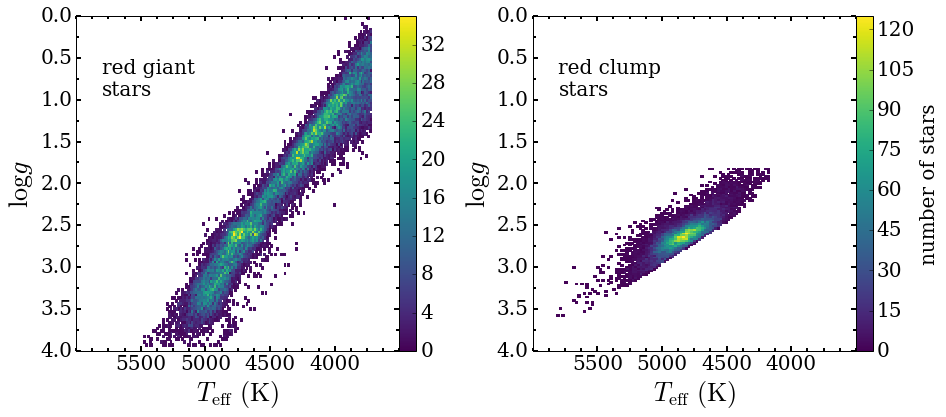

In [99]:
# Choose density colormap
default_cmap = 'viridis'
# Create figure of appropriate size
fig = plt.figure(figsize=(15,6))
# Create red giant subplot
ax = fig.add_subplot(121)
hist2d(fig,ax,rg.teff,rg.logg,bins=120,vmax=35)
plt.ylim(4,0)
plt.xlim(6000,3500)
# Don't plot on extremes of axis
plt.xticks(np.arange(4000,6000,500)[::-1],fontsize=20)
# Add minor ticks on both axes
xminorlocator = MultipleLocator(250./2)
ax.xaxis.set_minor_locator(xminorlocator)
yminorlocator = MultipleLocator(0.25)
ax.yaxis.set_minor_locator(yminorlocator)
plt.xticks(np.arange(4000,6000,500)[::-1],fontsize=20)
plt.yticks(fontsize=20)
# Adjust tick thickness and length
plt.tick_params(which='both', width=2)
plt.tick_params(which='major',length=5)
plt.tick_params(which='minor',length=3)
# Add axis labels
plt.ylabel(r'$\log g$',fontsize=26)
plt.xlabel(r'$T_{\mathrm{eff}}\,\,(\mathrm{K})$',fontsize=26)
# Shade sample area
#plt.axvline(4700,color='k',ls='--',lw=2)
#plt.axvline(4900,color='k',ls='--',lw=2)
#plt.fill_between(np.arange(4700,5000,100),4,0,alpha=0.1,color='k')
# Add sample description
plt.text(5800,0.5,'red giant\nstars',va='top')

# Create red clump subplot
ax = fig.add_subplot(122)
hist2d(fig,ax,rc.teff,rc.logg,clabel='number of stars',bins=80,vmax=125)
plt.ylim(4,0)
plt.xlim(6000,3500)
# Don't plot on extremes of x axis
plt.xticks(np.arange(4000,6000,500)[::-1],fontsize=20)
# Add minor ticks to both axes
xminorlocator = MultipleLocator(250./2)
ax.xaxis.set_minor_locator(xminorlocator)
yminorlocator = MultipleLocator(0.25)
ax.yaxis.set_minor_locator(yminorlocator)
plt.yticks(fontsize=20)
# Adjust tick thickness and length
plt.tick_params(which='both', width=2)
plt.tick_params(which='major',length=5)
plt.tick_params(which='minor',length=3)
# Add axis labels
plt.ylabel(r'$\log g$',fontsize=26)
plt.xlabel(r'$T_{\mathrm{eff}}\,\,(\mathrm{K})$',fontsize=26)
# Shade sample region
#plt.axvline(4700,color='k',ls='--',lw=2)
#plt.axvline(4900,color='k',ls='--',lw=2)
#plt.fill_between(np.arange(4700,5000,100),4,0,alpha=0.1,color='k')
# Label sample
plt.text(5800,0.5,'red clump\nstars',va='top')

# Reduce space between plots and save
plt.subplots_adjust(wspace=0.2)
plt.savefig('{0}/{1}'.format(figdir,'HRdiagram.pdf'))

## Figure 3 - Example polynomial fit for NGC 6819 in Teff

#### Run the box below using the bolded responses to the prompts

Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **CLUSTER**  
Default is full range. Match or slice? **match**  
Match value: **N6819**  
Data key: **done**

In [97]:
import empca_residuals
reload(empca_residuals)
from empca_residuals import *
oc = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)
oc.findResiduals(minStarNum=5,gen=True)
correction = oc.findCorrection(median=True,numpix=30.,savename='n6819_dr12_30px.pkl')

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: CLUSTER
Default is full range. Match or slice? m
Match value: N6819
And/or? done
Data key: done


Done getting filter information


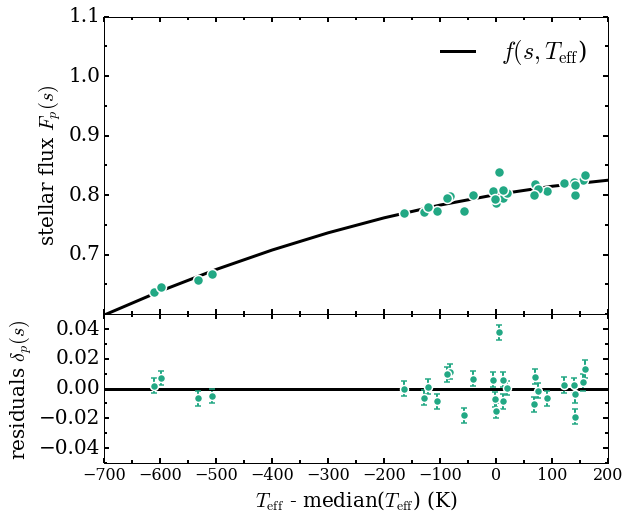

In [98]:
oc.plot_example_fit(indep=1,pixel=4313,xlabel='$T_{\mathrm{eff}}$ - median($T_{\mathrm{eff}}$) (K)',figsize=(10,8))
plt.subplots_adjust(left=0.2)
plt.savefig('{0}/example_fit.pdf'.format(figdir))

## Figure 4 - Comparing EMPCA model with data

In [158]:
subrc = empca_residuals('apogee','red_clump',maskFilter,ask=True,degree=2)
subrc.findResiduals(gen=False)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: TEFF
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 4900
Lower limit (Enter for minimum): 4800
Found good limits
And/or? and
Data key: MEANFIB
Default is full range. Match or slice? slice
Upper limit (Enter for maximum): 300
Lower limit (Enter for minimum): 100
Found good limits
And/or? done
Data key: done
Done getting filter information


In [363]:
subrcmodel = acs.pklread('/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935/eig20_minSNR50_corrNone_meanMed.pkl')
subrcmodel=getarrays(subrcmodel)
subrcmodel=reconstruct_EMPCA_data('/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',subrcmodel,minStarNum=5)
totalapprox = np.tile(np.ma.mean(subrcmodel.residuals,axis=0),(subrcmodel.residuals.shape[0],1))
nvec = 9
for i in range(nvec):
    totalapprox += np.outer(subrcmodel.coeff[:, i], subrcmodel.eigvec[i])

In [382]:
indx = np.random.randint(0,subrcmodel.residuals.shape[0])
print indx

1748


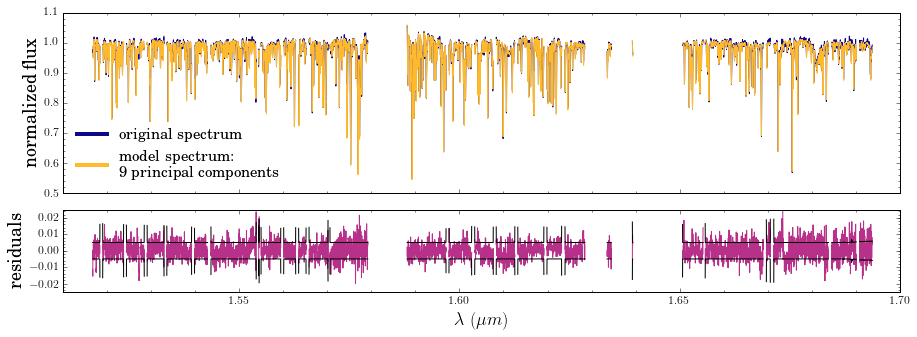

In [396]:
#indx = 200
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,3))
pixup = 8575
pixdown = 0
fitspec = toApStarGrid(subrcmodel.fitspec[indx])
fitspec = np.ma.masked_array(fitspec,mask=fitspec==0)
modelspec = toApStarGrid(totalapprox[indx])
modelspec = np.ma.masked_array(modelspec,mask=modelspec==0)
compspec = toApStarGrid(subrcmodel.spectra[indx])
compspec = np.ma.masked_array(compspec,mask=(modelspec.mask|fitspec.mask))
resspec = toApStarGrid(subrcmodel.residuals[indx])
resspec = np.ma.masked_array(resspec,mask=compspec.mask)
errspec = toApStarGrid(subrcmodel.spectra_errs[indx])
errspec = np.ma.masked_array(errspec,mask=compspec.mask)
wvs = pix2wv(np.arange(pixdown,pixup),apStarWavegrid = True)/1e4
stepsize = 0.05
xticks = np.linspace(wvs[0],wvs[-1]+stepsize,stepsize)
plt.figure(figsize=(15,5))
fit = plt.subplot2grid((3,1), (0, 0), rowspan=2)
fit.plot(wvs,compspec[pixdown:pixup],lw=1,color=colors[0],label='original spectrum')
fit.plot(wvs,(modelspec[pixdown:pixup]+fitspec[pixdown:pixup]),lw=1,color=colors[-1],label='model spectrum:\n {0} principal components'.format(nvec))
fit.set_xlim(wvs[0],wvs[-1])
xminorlocator = AutoMinorLocator()
fit.xaxis.set_minor_locator(xminorlocator)
yminorlocator = AutoMinorLocator()
fit.yaxis.set_minor_locator(yminorlocator)
fit.set_xticklabels(['']*len(xticks))
fit.set_ylabel('normalized flux',fontsize=18)
legend = fit.legend(loc='best',fontsize=15)
legend.get_frame().set_linewidth(0.0)
for legobj in legend.legendHandles:
    legobj.set_linewidth(4.0)
res = plt.subplot2grid((3,1), (2, 0))
res.plot(wvs,compspec[pixdown:pixup] - (modelspec[pixdown:pixup]+fitspec[pixdown:pixup]),lw=1,color=colors[1])
res.plot(wvs,-errspec[pixdown:pixup],color='k')
res.plot(wvs,errspec[pixdown:pixup],color='k')
res.set_xlim(wvs[0],wvs[-1])
res.set_ylim(-0.025,0.025)
xminorlocator = AutoMinorLocator()
res.xaxis.set_minor_locator(xminorlocator)
yminorlocator = AutoMinorLocator()
res.yaxis.set_minor_locator(yminorlocator)
res.set_ylabel('residuals',fontsize=18)
res.set_xlabel('$\lambda\,\,(\mu m)$',fontsize=18)
#plt.savefig('{0}/model_comp_star{1}.pdf'.format(figdir,indx))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



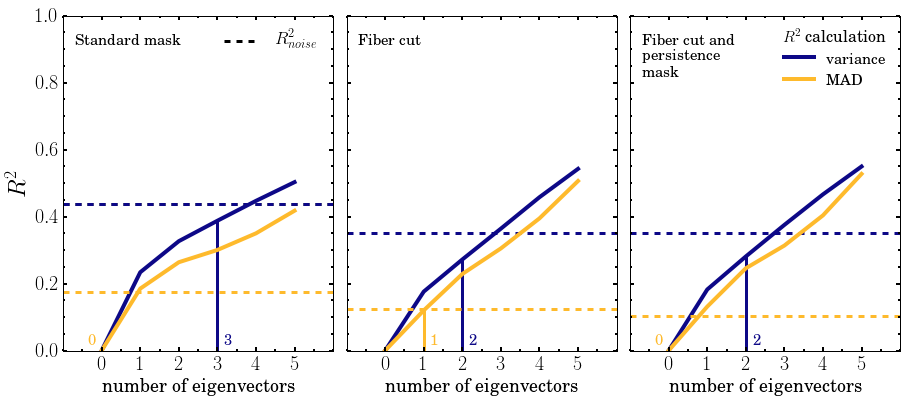

In [394]:
direcs = ['clusters_12_CLUSTER_matchN6819/bm4351',
          'clusters_12_CLUSTER_matchN6819_MEANFIB_up300.0_lo100.0/bm4351',
          'clusters_12_CLUSTER_matchN6819_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard mask',
          'Fiber cut',
          'Fiber cut and \npersistence\nmask']
models = ['eig5_minSNR50_corrNone_var.pkl',
          'eig5_minSNR50_corrNone_meanMed.pkl']
labels = ['variance','MAD']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrastR2_methods(direcs,models,labels,colors,titles=titles,figsize=(15,6),tingpredict=False,savename='n6819_comparison.pdf')


## Figure 6 - Ncells for NGC 6819

## M13 Comparison

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



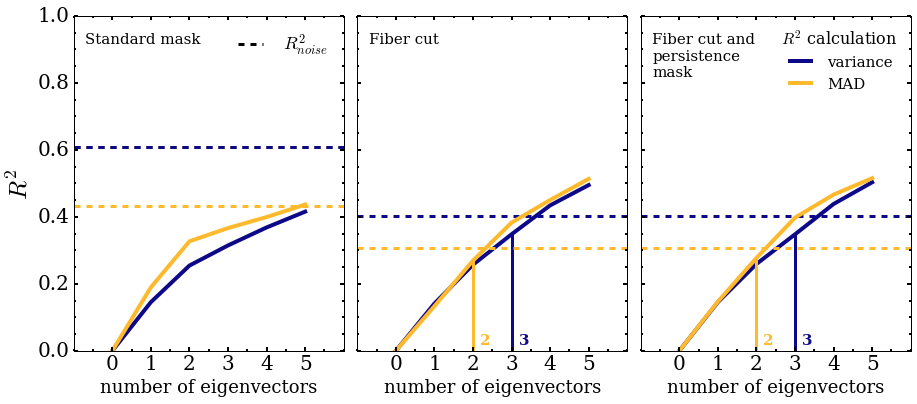

In [9]:
direcs = ['clusters_12_CLUSTER_matchM13/bm4351',
          'clusters_12_CLUSTER_matchM13_MEANFIB_up300.0_lo100.0/bm4351',
          'clusters_12_CLUSTER_matchM13_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard mask',
          'Fiber cut',
          'Fiber cut and \npersistence\nmask']
models = ['eig5_minSNR50_corrNone_var.pkl',
          'eig5_minSNR50_corrNone_meanMed.pkl']
labels = ['variance','MAD']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrastR2_methods(direcs,models,labels,colors,titles = titles,figsize=(15,6),tingpredict=False,savename='m13_comparison.pdf')


## Figure 11 - R2 for red clump sample with a large number of eigenvectors

#### To create the data for this figure, run the following in the same directory as this notebook

python run_all_empca.py

#### Then fill out the prompts with the bolded responses

Which sample: red clump, red giant or cluster? **red clump**  
How many eigenvectors in the model (Enter for 60): **500**  
What's the minimum signal to noise? (Enter for 50): *press Enter*   
Shall I get data from scratch? (Enter for yes): **no**  
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **4900**  
Lower limit (Enter for minimum): **4800**  
Found good limits  
Data key: **done** 

#### This will take about a day to complete, so run it in the background. Once it's done, run the box below

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



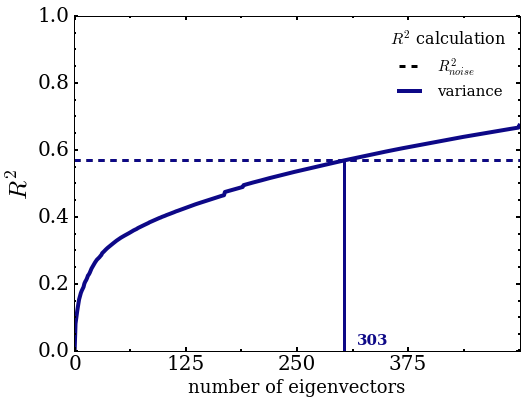

In [10]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0/bm7935']
models = ['eig500_minSNR50_corrNone_var.pkl']
labels =  ['variance']
contrastR2_methods(direcs,models,labels,colors,figsize=(8,6),tingpredict=False,savename='mammoth_eigvec.pdf')

## Figure 12 - R2 for red clump 100K slice subsample comparison

#### To create the data for this figure, run the following boxes

#### First run the box below fill out the prompts with the bolded responses

Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **TEFF**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **4900**  
Lower limit (Enter for minimum): **4800**  
Found good limits 
Data key: **done** 


IOError: [Errno 2] No such file or directory: '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm4351/eig20_minSNR50_corrNone_meanMed.pkl'

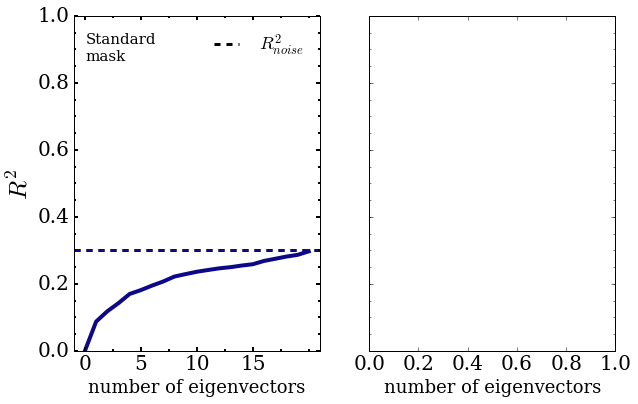

In [240]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard\nmask',
          'Fiber cut and\nstandard\nmask',
          'Fiber cut and\npersistence\nmask']
models = ['eig20_minSNR50_corrNone_var.pkl',
          'eig20_minSNR50_corrNone_meanMed.pkl']
labels = ['variance',
          'MAD']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrastR2_methods(direcs,models,labels,colors,titles=titles,figsize=(15,6),tingpredict=False,subsamples=5,savename='rc_method_compare.pdf')

In [241]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935']
labels = ['Standard\nmask',
          'Fiber cut and\nstandard\nmask',
          'Fiber cut and\npersistence\nmask']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
colour = plt.get_cmap('viridis')(np.linspace(0,0.9,len(models)*len(direcs)))
sample_compare_nvec(direcs,models,labels,subsamples=5,figsize=(8,8),colour=colour,savename='rc_nvec_example.pdf',rotation='horizontal',ha='center')

IOError: [Errno 2] No such file or directory: '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0/bm4351/eig20_minSNR50_corrNone_meanMed.pkl'

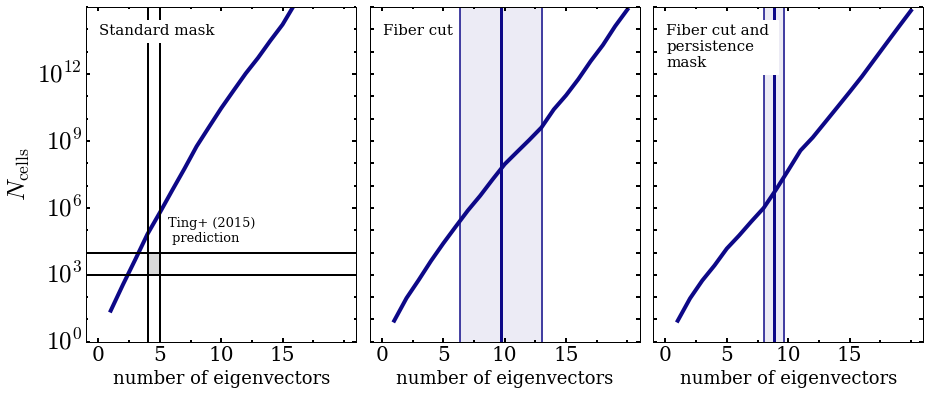

In [156]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard mask',
          'Fiber cut',
          'Fiber cut and \npersistence\nmask']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
labels = ['']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrast_Ncells(direcs,models,labels,colors,titles=titles,figsize=(15,6),tingpredict=True,subsamples=5,savename='rc_Ncells_compare.pdf')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:74: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.

8
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:100: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

9


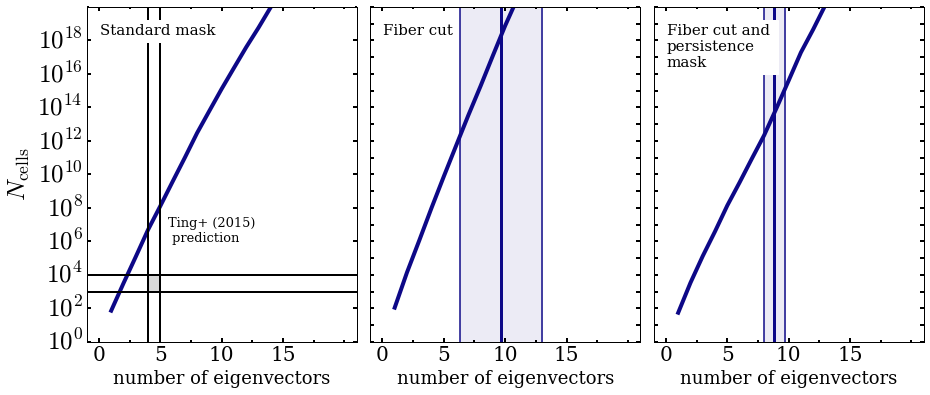

In [230]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard mask',
          'Fiber cut',
          'Fiber cut and \npersistence\nmask']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
labels = ['']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrast_Ncells(direcs,models,labels,colors,titles=titles,figsize=(15,6),ybounds=(1,1e20),tingpredict=True,generate=True,subsamples=5,denom=pessimh)

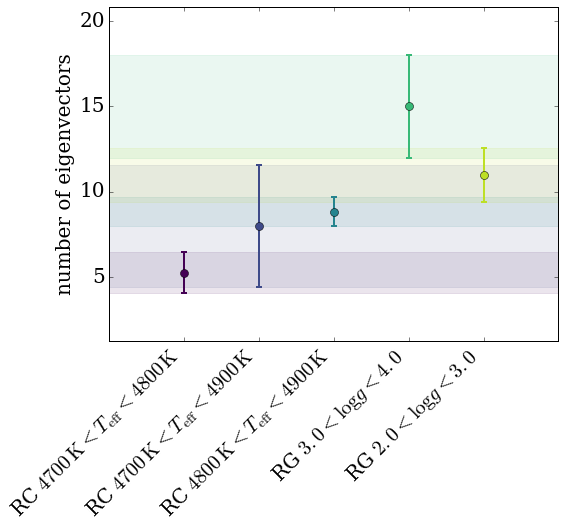

In [147]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4800.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_LOGG_up4.0_lo3.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_LOGG_up3.0_lo2.0_MEANFIB_up300.0_lo100.0/bm7935']
labels = ['RC $4700\,\mathrm{K} < T_{\mathrm{eff}} < 4800\,\mathrm{K}$',
          'RC $4700\,\mathrm{K} < T_{\mathrm{eff}} < 4900\,\mathrm{K}$',
          'RC $4800\,\mathrm{K} < T_{\mathrm{eff}} < 4900\,\mathrm{K}$',
          'RG $3.0 < \log g < 4.0$',
          'RG $2.0 < \log g < 3.0$']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
colours = plt.get_cmap('viridis')(np.linspace(0,0.9,len(models)*len(direcs)))
sample_compare_nvec(direcs,models,labels,subsamples=5,figsize=(8,8),colour=colours,savename='nvec_comp.pdf',rotation=45,ha='right',bottom_margin=0.35)

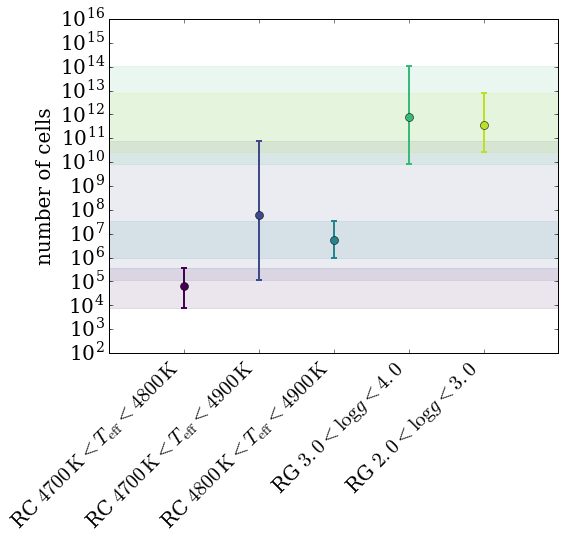

In [148]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4800.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_LOGG_up4.0_lo3.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_LOGG_up3.0_lo2.0_MEANFIB_up300.0_lo100.0/bm7935']
labels = ['RC $4700\,\mathrm{K} < T_{\mathrm{eff}} < 4800\,\mathrm{K}$',
          'RC $4700\,\mathrm{K} < T_{\mathrm{eff}} < 4900\,\mathrm{K}$',
          'RC $4800\,\mathrm{K} < T_{\mathrm{eff}} < 4900\,\mathrm{K}$',
          'RG $3.0 < \log g < 4.0$',
          'RG $2.0 < \log g < 3.0$']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
colours = plt.get_cmap('viridis')(np.linspace(0,0.9,len(models)*len(direcs)))
sample_compare_ncells(direcs,models,labels,subsamples=5,figsize=(8,8),colour=colours,savename='ncells_comp.pdf',rotation=45,ha='right',bottom_margin=0.35)

## Figure 14 - R2 for red giant subsample comparison

#### To create the data for this figure, run the following in the same directory as this notebook

python run_all_empca.py

#### Then fill out the prompts with the bolded responses

Which sample: red clump, red giant or cluster? **red giant**  
How many eigenvectors in the model (Enter for 60): *press Enter*  
What's the minimum signal to noise? (Enter for 50): *press Enter*   
Shall I get data from scratch? (Enter for yes): **no**  
Which data release? (Enter for 13): **12**  
Type done at any prompt when finished  
Data key: **LOGG**  
Default is full range. Match or slice? **slice**  
Upper limit (Enter for maximum): **3.0**  
Lower limit (Enter for minimum): **2.0**  
Found good limits 
Data key: **done** 

#### Then repeat this script once more, with all prompts the same except for the limits. The other other run should have 

Upper limit (Enter for maximum): **4.0**  
Lower limit (Enter for minimum): **3.0**  

#### This will take about four hours to complete for each run, so run in parallel if possible. Once it's done, run the box below

In [ ]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4900.0_lo4800.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['Standard mask',
          'Fiber cut',
          'Fiber cut and \npersistence\nmask']
models = ['eig20_minSNR50_corrNone_var.pkl',
          'eig20_minSNR50_corrNone_meanMed.pkl']
labels = ['variance','MAD']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrastR2_methods(direcs,models,labels,colors,titles=titles,figsize=(15,6),tingpredict=False,subsamples=5,savename='rg_method_compare.pdf')

In [ ]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4800.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4900.0_lo4700.0_MEANFIB_up300.0_lo100.0/bm7935',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_giant_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935']
titles = ['$4700\,\mathrm{K} < T_{\mathrm{eff}} < 4800 \mathrm{K}$',
          '$4700\,\mathrm{K} < T_{\mathrm{eff}} < 4900 \mathrm{K}$',
          '$4800\,\mathrm{K} < T_{\mathrm{eff}} < 4900 \mathrm{K}$']
models = ['eig20_minSNR50_corrNone_meanMed.pkl']
#labels = ['variance','MAD']
colors = plt.get_cmap('plasma')(np.linspace(0,0.85,len(models)))

contrastR2_methods(direcs,models,colors,titles=titles,figsize=(15,6),tingpredict=False,subsamples=5,savename='rc_sample_compare.pdf')

## Figure 15 - Ncells for red giant subsample comparison

## Figure 16 - Eigenvectors in M13

In [26]:
import apogee.spec.window as wn

elems = ['C','N','O','Na','Mg','Al','Si','S','K','Ca','Ti','V','Mn','Fe','Ni']

# Store information about where element windows are                                                                                         
# Track by element name                                                                                                                     
                                                                                                                                        
elemwindows = {}                                                                                                                            
# Track by array in order of periodic table
# Find normalized windows
normwindows = np.zeros((len(elems),aspcappix))
# Find where windows are non-zero
tfwindows = np.zeros((len(elems),aspcappix))
e = 0                                                                                                                                       
for elem in elems:                                                                                                                          
    w = wn.read(elem,dr=13,apStarWavegrid=False)                                                                                            
    # Calculate normalized windows
    nw = np.ma.masked_array(w/np.sqrt(np.sum(w)))                                                                                           
    elemwindows[elem] = w                                                                                                                   
    normwindows[e] = nw    
    # Find where windows are nonzero
    tfwindows[e] = nw!=0
    e+=1                                                                                                                                    
tfwindows = tfwindows.astype(int)

def window_project(es):
    """
    Project eigenvectors onto each of the element windows and renormalize
    
    es:     A list of eigenvectors
    """
    elemeigs = np.dot(es,normwindows.T)
    for e in elemeigs:
        e /= np.sqrt(np.sum(e**2))
    return elemeigs

In [29]:
def get_colors(n,cmap='plasma'):
    """
    Find n maximally separated colours from a colour map.
    
    n:     Number of colours to get
    cmap:  Colour map to draw colours from.
    
    """
    # Draw colours in order
    colors = plt.get_cmap(cmap)(np.linspace(0,0.90,n))
    # Split colours into first and last half of the colour map
    fronthalf = colors[:np.ceil(n/2.)]
    backhalf = colors[np.ceil(n/2.):]
    colors = np.empty(colors.shape)
    # Weave colors together so adjacent colours are maximally separated on the colour map
    colors[0::2] = fronthalf
    colors[1::2] = backhalf
    return colors

def plot_fullvec(eigvecs,n=5,pixup=7214,pixdown=0,oset=0.08,label=True):
    """
    Plot eigenvectors up to n from model.
    
    eigvecs:   Array of eigenvectors
    n:         Number of eigenvectors to plot
    pixup:     Maximum pixel to plot to
    pixdown:   Minimum pixel to plot to
    oset:      Offset between eigenvectors
    label:     If True, label each eigenvector with its number
    """
    colors = get_colors(n)
    # Tracks where the zeropoint is with respect to true zero
    offset = 0
    yticks = np.zeros(n*3)
    yticklocs = np.zeros(n*3)
    ax = plt.subplot(111)
    k = 0
    for i in range(n):
        plt.axhline(offset,color='k',lw=1)
        if label:
            plt.plot(np.arange(pixdown,pixup),eigvecs[i][pixdown:pixup]+offset,lw=0.5,color=colors[i],label='eigenvector {0}'.format(i+1))
        elif not label:
            plt.plot(np.arange(pixdown,pixup),eigvecs[i][pixdown:pixup]+offset,lw=0.5,color=colors[i])
        # Track ytick labels and location
        yticks[k:k+3] = np.array([-0.02,0.0,0.02])
        yticklocs[k:k+3] = np.array([offset-0.02,offset,offset+0.02])
        k+=3
        # Move zeropoint
        offset+=oset
    # Create legend
    legend = plt.legend(loc='best',fontsize=15,ncol=5)
    legend.get_frame().set_linewidth(0.0)
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0)
    #plt.yticks(np.arange(0,oset*n+oset,oset),np.zeros(n))
    plt.yticks(yticklocs,yticks,fontsize=15)
    xminorlocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(xminorlocator)
    plt.xticks(fontsize=15)
    ylim=plt.ylim(-0.1,offset+0.1)
    xlim=plt.xlim(pixdown,pixup)
    
def plot_projvec(model,n=5,yup=0.15,ydown=-0.3):
    # Project eigenvectors onto element windows
    ws = window_project(model.eigvec[:n])
    colors = get_colors(n=n)
    plt.figure(figsize=(16,8))
    for w in range(len(ws)):
        # Plot projected eigenvectors
        plt.plot(ws[w],'o-',color=colors[w],lw=3,label='eigenvector {0}'.format(w+1),markersize=10,markeredgecolor='w')
        plt.fill_between(np.arange(0,len(ws[w])),np.zeros(len(ws[w])),ws[w],color=colors[w])
    # Plot legend
    legend = plt.legend(loc='best',fontsize=20,ncol=2)
    legend.get_frame().set_linewidth(0.0)
    for legobj in legend.legendHandles:
        legobj.set_linewidth(3.0)
    xtick = plt.xticks(np.arange(0,15),elems)
    ylim=plt.ylim(ydown,yup)

In [240]:
m13 = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: CLUSETER
Got a bad key. Try choosing one of  ['AL_H', 'CA_H', 'CLUSTER', 'C_H', 'DEC', 'FE_H', 'GLAT', 'GLON', 'K_H', 'LOGG', 'LOGG_ERR', 'MEANFIB', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'RA', 'SIGFIB', 'SI_H', 'S_H', 'TEFF', 'TEFF_ERR', 'TI_H', 'V_H']
Data key: CLUSTER
Default is full range. Match or slice? m
Match value: M13
And/or? done
Data key: done
Done getting filter information


In [242]:
m13.findResiduals(gen=True)

In [ ]:
m13.samplesplit()

In [33]:
m13model = acs.pklread('clusters_12_CLUSTER_matchM13_MEANFIB_up300.0_lo100.0/bm7935/eig5_minSNR50_corrNone_meanMed.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



TypeError: 'smallEMPCA' object does not support indexing

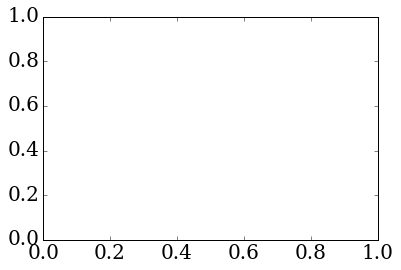

In [35]:
getarrays(m13model)
n=5
pixup = 7214
pixdown = 0
plot_fullvec(m13model,n=n,pixup=pixup,pixdown=pixdown)

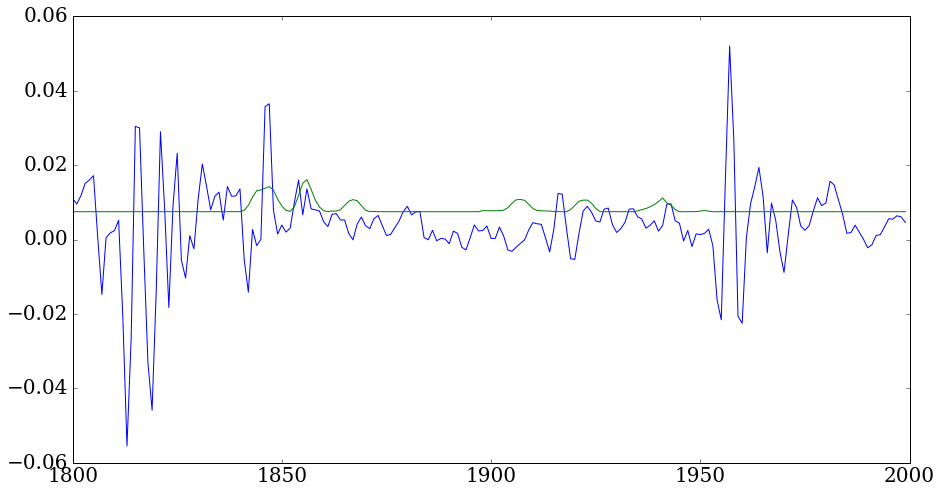

In [30]:
pixup=2000
pixdown = 1800
plt.figure(figsize=(15,8))
pixels = np.arange(0,7214)
plt.plot(pixels[pixdown:pixup],m13model.eigvec[0][pixdown:pixup])
plt.plot(pixels[pixdown:pixup],((np.sum(normwindows,axis=0)/15.)+0.0075)[pixdown:pixup])

In [31]:
m13model.eigvec[0][150]

masked

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



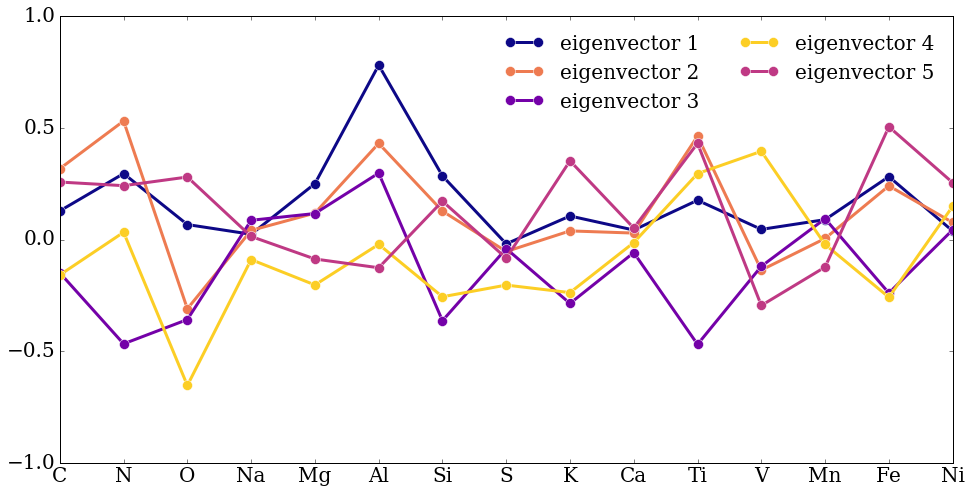

In [49]:
n=5
plot_projvec(m13model,n=n,yup=1,ydown=-1)

## Figure 17 - Eigenvectors in red clump

In [27]:
direcs = ['/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm4351',
          '/geir_data/scr/price-jones/Data/apogee_dim_reduction/red_clump_12_TEFF_up4900.0_lo4800.0_MEANFIB_up300.0_lo100.0/bm7935']
models = ['eig20_minSNR50_corrNone_var.pkl',
          'eig20_minSNR50_corrNone_meanMed.pkl']

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



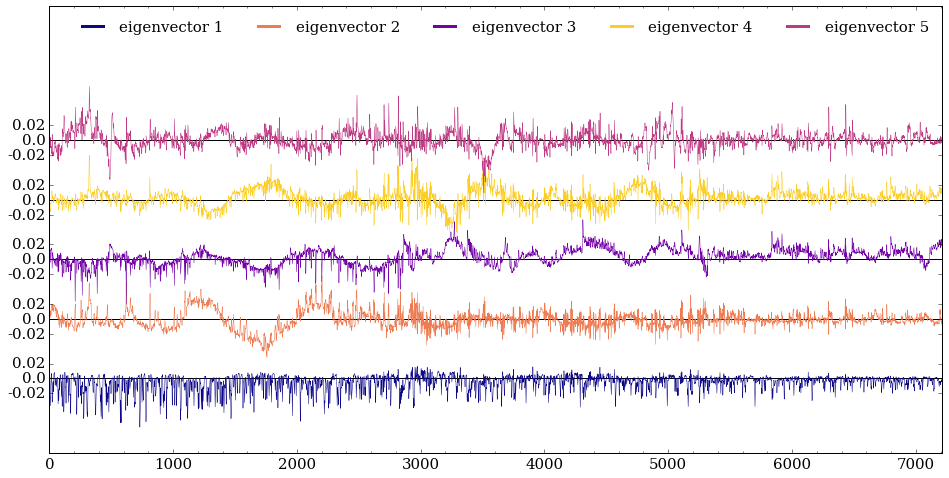

In [33]:
n=5
pixup = 7214
pixdown = 0
subrcmodel = np.load('{0}/eig20_minSNR50_corrNone_meanMed.pkl_data.npz'.format(direcs[0]))
eigvec = subrcmodel['eigvec']
plt.figure(figsize=(16,8))
plot_fullvec(eigvec,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



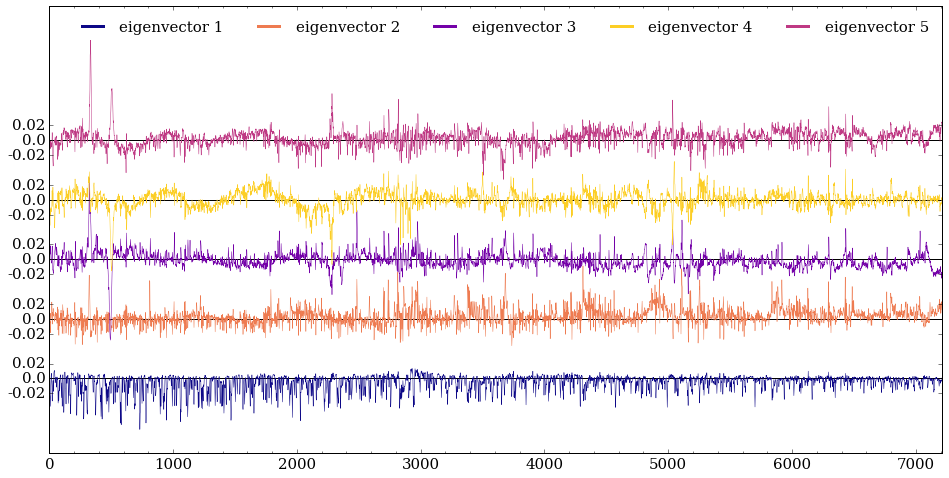

In [32]:
n=5
pixup = 7214
pixdown = 0
subrcmodel = np.load('{0}/eig20_minSNR50_corrNone_meanMed.pkl_data.npz'.format(direcs[1]))
eigvec = subrcmodel['eigvec']
plt.figure(figsize=(16,8))
plot_fullvec(eigvec,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



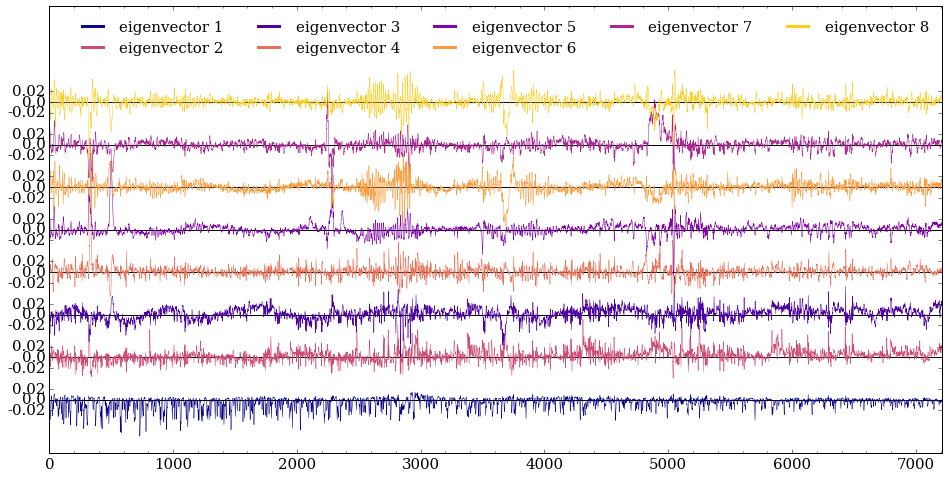

In [30]:
n=8
pixup = 7214
pixdown = 0
subrcmodel = np.load('{0}/eig20_minSNR50_corrNone_meanMed.pkl_data.npz'.format(direcs[2]))
eigvec = subrcmodel['eigvec']
plt.figure(figsize=(16,8))
plot_fullvec(eigvec,n=n,pixup=pixup,pixdown=pixdown)
plt.savefig('{0}/aggressive_eigvec.pdf'.format(figdir))

## Figure 18 - Eigenvectors in N6819

In [116]:
n6819 = empca_residuals('apogee','clusters',maskFilter,ask=True,degree=2)

Which data release? (Enter for 13): 12
Type done at any prompt when finished
Data key: CLUSTER
Default is full range. Match or slice? m
Match value: N6819
And/or? done
Data key: done
Done getting filter information


In [ ]:
n6819.samplesplit()

In [35]:
n6819model = acs.pklread('clusters_12_CLUSTER_matchN6819/eig5_minSNR50_corrNone_mean.pkl')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



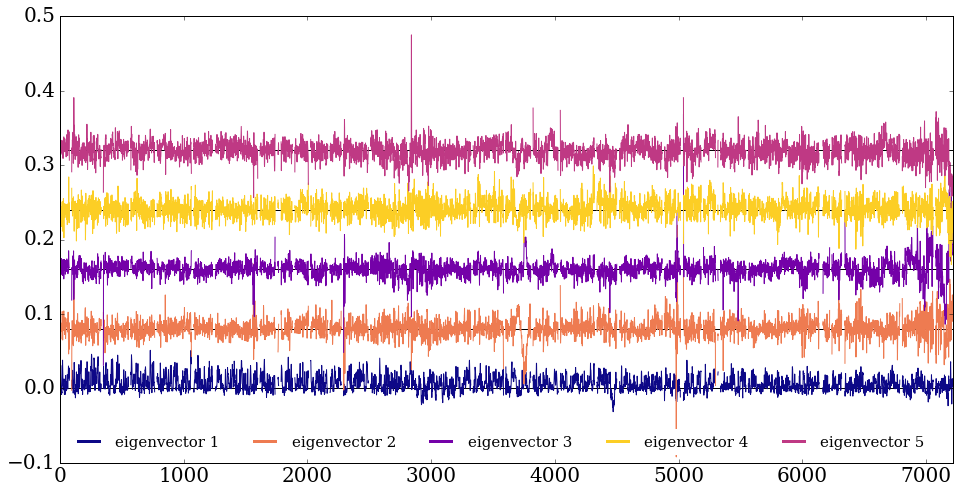

In [36]:
n=5
pixup = 7214
pixdown = 0
plot_fullvec(n6819model,n=n,pixup=pixup,pixdown=pixdown)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



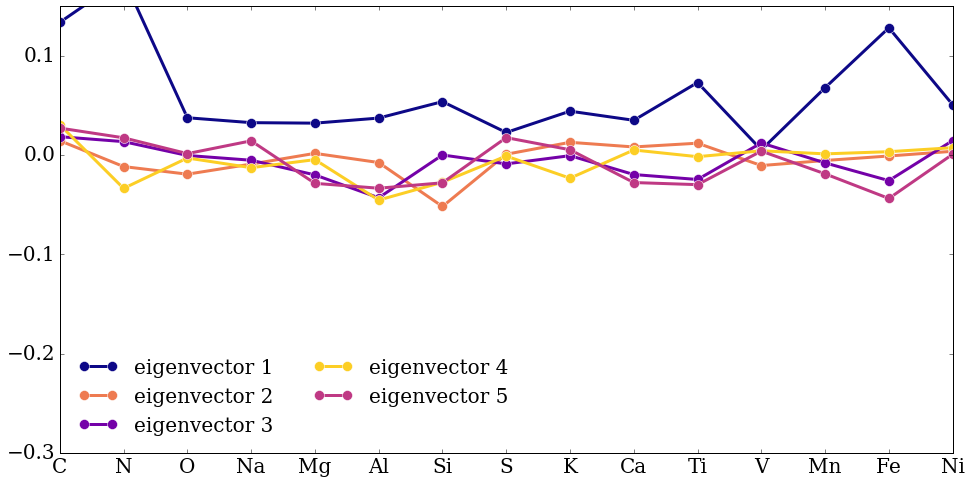

In [37]:
n=5
plot_projvec(n6819model,n=n,yup=0.15,ydown=-0.3)